In [1]:
# 使用MNIST数据集，MNIST相当于是机器学习界的helloworld
import sklearn 
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
#mnist=fetch_mldata('mnist-original', data_home='C:/Users/yzy/Desktop/MNIST_DATA')  这个方法暂时拿不到mnist

In [2]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST")

Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


In [3]:
trainmnist=mnist.train.images
testmnist=mnist.test.images
trainlabelmnist=mnist.train.labels
testlabelmnist=mnist.test.labels

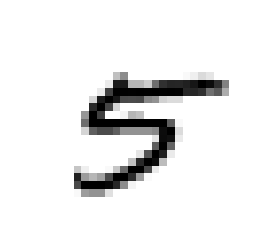

In [20]:
# 画出大概的图像来看一看
import matplotlib.pyplot as plt
import matplotlib
target_image=trainmnist[36000] # 提取某一行
target_image_mm=target_image.reshape(28,28) # 每一个像素点大概是28*28大小
plt.imshow(target_image_mm,cmap='binary',interpolation='nearest')
plt.axis('off')
plt.show()
plt.close()

In [5]:
# 我们先训练一个二分类器
trainlabelmnist_5=(trainlabelmnist==5)
testlabelmnist_5=(testlabelmnist==5)

In [6]:
# 使用随机梯度下降分类方法
from sklearn.linear_model import SGDClassifier # 默认是使用线性支持向量机作为基本的分类器！！
sgdc=SGDClassifier(random_state=42)
sgdc.fit(trainmnist,trainlabelmnist_5)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [7]:
from sklearn.model_selection import cross_val_score # 交叉验证查看准确率
score=cross_val_score(sgdc,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')

In [8]:
score # 可以看到准确率比较高，但是我们也要想为什么这么高，这时有原因的，因为其实不是5的数据特别多，是5的数据特别少，所以进行2分类的时候
# 只要判断不是5 就能获得很高的accuracy,但是实际上这是很不准确的

array([ 0.96280135,  0.96449026,  0.96689031])

In [9]:
# 另一个交叉验证--自己写函数来验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfold=StratifiedKFold(n_splits=3,random_state=42) # 将这个随机划分为三份
for trainix,testix in skfold.split(trainmnist,trainlabelmnist_5):
    clonesgdc=clone(sgdc)
    train_fold_train=trainmnist[trainix]
    train_fold_test=trainmnist[testix]
    train_fold_train_label=trainlabelmnist_5[trainix]
    train_fold_test_label=trainlabelmnist_5[testix]
    clonesgdc.fit(train_fold_train,train_fold_train_label)
    predict=clonesgdc.predict(train_fold_test)
    ncorrect=np.sum(predict==train_fold_test_label)
    print(ncorrect/len(predict))

0.962801352678
0.964490263459
0.966890307096


In [10]:
# 构建一个估计器
from sklearn.base import BaseEstimator
class NotFiveAccuracy(BaseEstimator):
    def fit(self,X,y):
        return self
    def predict(self,X):
        return(np.zeros(shape=(len(X),1),dtype=bool))
# 这个是用来将传入的X转化为相同长度的0矩阵，也就是说将这个0矩阵和不是为5的比较以下，看看是不是不是5的居多
from sklearn.model_selection import cross_val_score
notfive=NotFiveAccuracy()
cross_val_score(notfive,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')  # 从结果可以看到其实不是5的数据尤其多
# 所以说明上面哪个而分类器事实上并没有那么的准确，只要将所有的结果都表示为False,就能有90%的准确率了，实际上这时很错误的

array([ 0.91087597,  0.90814378,  0.90896198])

In [11]:
from sklearn.model_selection import cross_val_predict
prediction=cross_val_predict(sgdc,trainmnist,trainlabelmnist_5,cv=3) # 返回每一个元素都作为测试集时的训练结果

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainlabelmnist_5,prediction)

array([[48993,  1020],
       [  920,  4067]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score,recall_score
precision_score(trainlabelmnist_5,prediction) # 这里判断阴率和阳率是用True和False来判断的是阴还是阳的

0.79948889325732264

In [14]:
recall_score(trainlabelmnist_5,prediction)

0.81552035291758573

In [15]:
from sklearn.metrics import f1_score
f1_score(trainlabelmnist_5,prediction)

0.80742505459598968

In [22]:
 # SGDC本质上是计算出一个决策函数的值，当这个决策函数的值大于某个阈值，分为正类，否则分为负类
pred=sgdc.decision_function([target_image])
# 所以说本质上我们可以不使用fit和predict来预测，fit里面的threshold一般设
#置为0，所以我们可以自己对threshold进行设置
y_target_image_pred=pred>0
y_target_image_pred

array([ True], dtype=bool)

In [24]:
y_target_image_pred=pred>2000 # 当我们把阈值设置为2000时，此时的预测结果便是为false
y_target_image_pred

array([False], dtype=bool)

In [57]:
# 所以到底使用哪个阈值好呢，我们来看一下
from sklearn.model_selection import cross_val_predict
prescore=cross_val_predict(sgdc,trainmnist,trainlabelmnist_5,cv=3,method='decision_function')

In [70]:
from sklearn.metrics import precision_recall_curve
# 这个函数是用于计算在不同的thresholds下不同的precisons，recallls
precisions,recalls,thresholds=precision_recall_curve(trainlabelmnist_5,prescore[:,1])

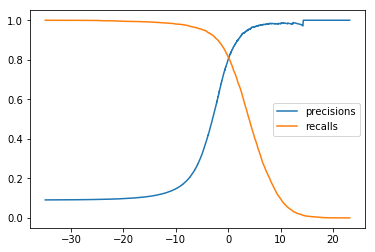

In [74]:
# 第一种选择precisions和recalls的方法--
# 看这样的图片就可以找出合适的threshold来控制precision和recalls
import matplotlib.pyplot as plt
plt.plot(thresholds,precisions[:-1],label='precisions')
plt.plot(thresholds,recalls[:-1],label='recalls')
plt.legend()
plt.show()
plt.close()

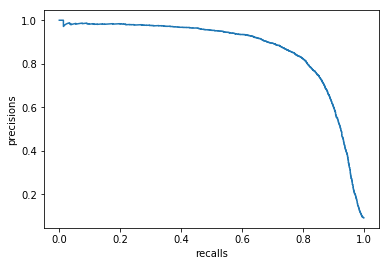

In [79]:
plt.plot(recalls,precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.show()
plt.close()
# 可以看到precisions在recalls等于0.8左右的时候开始急剧下降，所以需要找一个可能的值
# 把precisions和recalls控制在一个合理的范围内

In [106]:
pred=sgdc.decision_function(trainmnist)>2

In [107]:
precision_score(y_true=trainlabelmnist_5,y_pred=pred)

0.89950106913756234

In [108]:
recall_score(y_true=trainlabelmnist_5,y_pred=pred)

0.75917385201523957